In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setup

In [2]:

# Parameters
speed_of_sound = 1540  # Speed of sound in tissue in m/s
frequency = 5e6  # Frequency of ultrasound in Hz
wavelength = speed_of_sound / frequency
num_elements = 64  # Number of elements in the transducer array
element_spacing = wavelength / 2  # Half-wavelength spacing
sampling_rate = 50e6  # Sampling rate in Hz


## Simulate Echo Reception

In [4]:
# Create medium with reflectors at different depths
reflectors_depths = np.array([0.02, 0.04, 0.06, 0.08])  # Depths in meters
reflectors_amplitudes = np.array([1, 0.5, 0.7, 0.3])  # Reflectivity

# Create received signal matrix
max_depth = np.max(reflectors_depths)
travel_time_max = 2 * max_depth / speed_of_sound  # Round trip travel time for the deepest reflector
sample_points = int(travel_time_max * sampling_rate) + 1  # Number of sample points based on max depth and some buffer
received_signals = np.zeros((num_elements, sample_points))  # Adjust the array size

# Simulate echoes received by each element
for i, depth in enumerate(reflectors_depths):
    travel_time = 2 * depth / speed_of_sound  # Round trip time
    sample_index = int(travel_time * sampling_rate)
    amplitude = reflectors_amplitudes[i]
    if sample_index < sample_points:
        received_signals[:, sample_index] += amplitude


In [5]:
received_signals

array([[0. , 0. , 0. , ..., 0. , 0. , 0.3],
       [0. , 0. , 0. , ..., 0. , 0. , 0.3],
       [0. , 0. , 0. , ..., 0. , 0. , 0.3],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0.3],
       [0. , 0. , 0. , ..., 0. , 0. , 0.3],
       [0. , 0. , 0. , ..., 0. , 0. , 0.3]])

## Beam Focusing and Steering

In [7]:
# Dynamic focusing for each sample point
dynamic_focus_delay = np.zeros((num_elements, sample_points))

for sample_point in range(sample_points):
    focus_depth = sample_point / sampling_rate * speed_of_sound / 2
    for element in range(num_elements):
        element_position = (element - num_elements / 2) * element_spacing
        distance = np.sqrt(focus_depth**2 + element_position**2)
        time_delay = distance / speed_of_sound
        dynamic_focus_delay[element, sample_point] = time_delay

# Apply dynamic focusing delays to received signals
focused_signals = np.zeros_like(received_signals)
for element in range(num_elements):
    for sample_point in range(sample_points):
        delay_samples = int(dynamic_focus_delay[element, sample_point] * sampling_rate)
        if sample_point + delay_samples < sample_points:
            focused_signals[element, sample_point] += received_signals[element, sample_point + delay_samples]


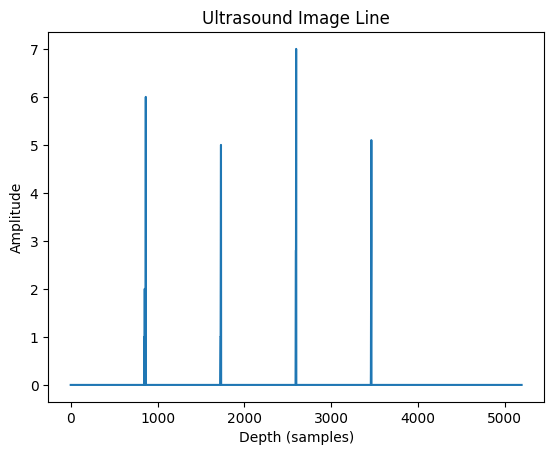

In [8]:
image_line = np.sum(focused_signals, axis=0)

plt.figure()
plt.plot(image_line)
plt.title('Ultrasound Image Line')
plt.xlabel('Depth (samples)')
plt.ylabel('Amplitude')
plt.show()


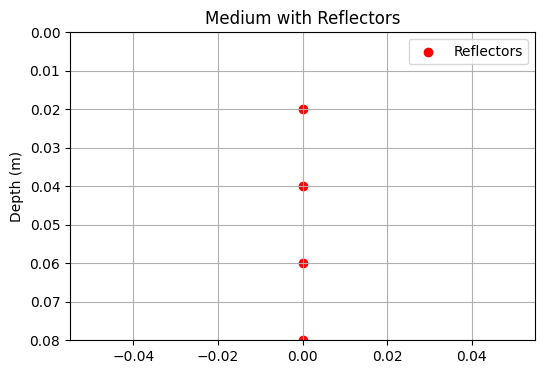

In [9]:
plt.figure(figsize=(6, 4))
plt.scatter([0]*len(reflectors_depths), reflectors_depths, c='red', marker='o', label='Reflectors')
plt.ylim(0, depth)
plt.gca().invert_yaxis()  # Invert y-axis to have depth increase downwards
plt.title('Medium with Reflectors')
plt.ylabel('Depth (m)')
plt.grid(True)
plt.legend()
plt.show()


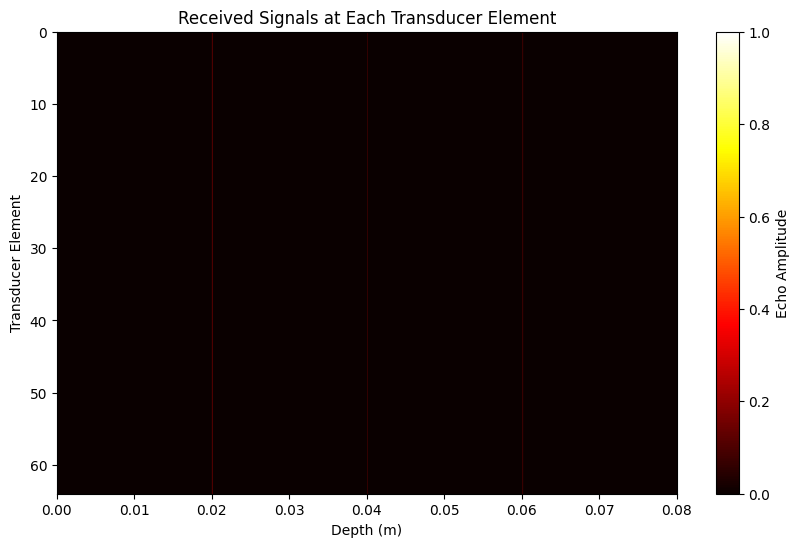

In [10]:
plt.figure(figsize=(10, 6))
plt.imshow(received_signals, aspect='auto', extent=[0, depth, num_elements, 0], cmap='hot')
plt.colorbar(label='Echo Amplitude')
plt.title('Received Signals at Each Transducer Element')
plt.xlabel('Depth (m)')
plt.ylabel('Transducer Element')
plt.show()


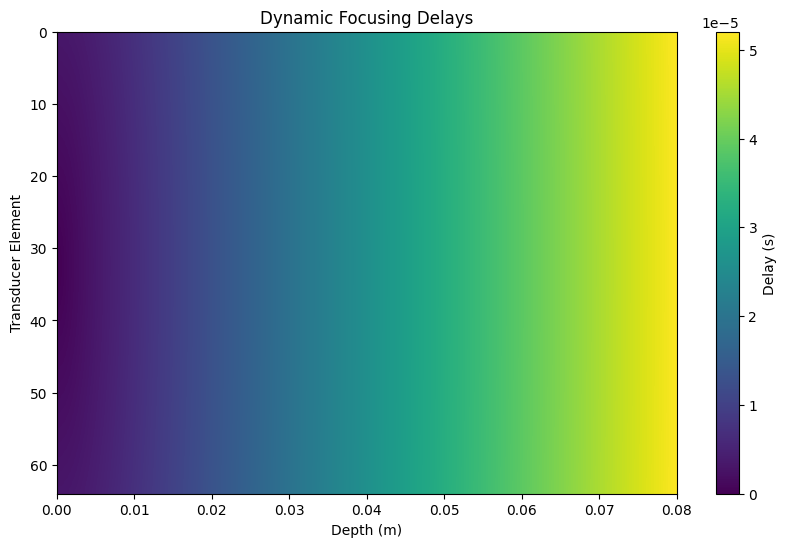

In [11]:
plt.figure(figsize=(10, 6))
plt.imshow(dynamic_focus_delay, aspect='auto', extent=[0, depth, num_elements, 0], cmap='viridis')
plt.colorbar(label='Delay (s)')
plt.title('Dynamic Focusing Delays')
plt.xlabel('Depth (m)')
plt.ylabel('Transducer Element')
plt.show()


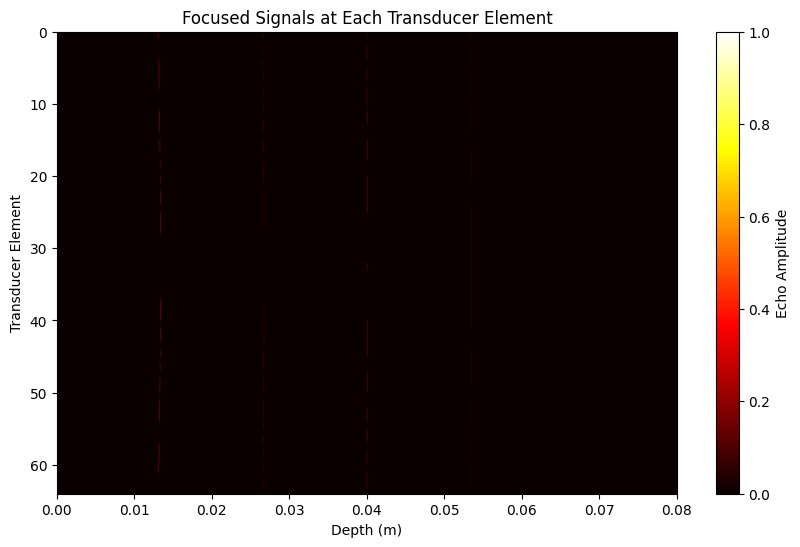

In [12]:
plt.figure(figsize=(10, 6))
plt.imshow(focused_signals, aspect='auto', extent=[0, depth, num_elements, 0], cmap='hot')
plt.colorbar(label='Echo Amplitude')
plt.title('Focused Signals at Each Transducer Element')
plt.xlabel('Depth (m)')
plt.ylabel('Transducer Element')
plt.show()


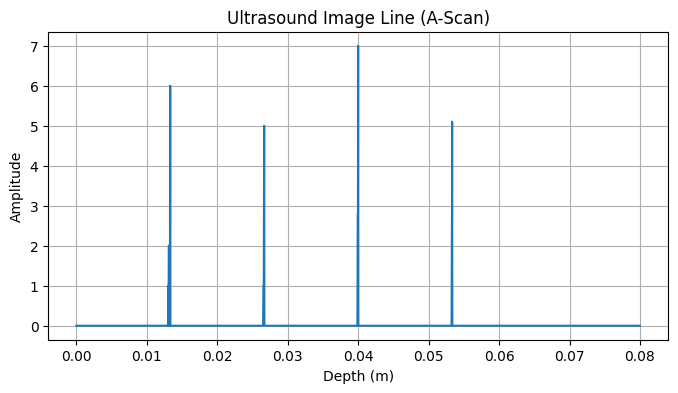

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, depth, sample_points), image_line)
plt.title('Ultrasound Image Line (A-Scan)')
plt.xlabel('Depth (m)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
